<a href="https://colab.research.google.com/github/chandrakanta-chaudhury/Machine-Learning/blob/master/product_recommend_with_Transferlearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np  
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os

import warnings
warnings.filterwarnings('ignore')


In [ ]:
#we will use here fashion dataset for recommendation . as we have images and csv(hanving appeareal details, gender , colour and other details)
# we will create embeddings of it and will check how similar they are for recommendation .to create recommendation instead of 
#creating Conv model and training it , we will use transfer learning for it 
style_df = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/styles.csv', error_bad_lines=False, nrows=10000)
images_df = pd.read_csv('/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/images.csv')

b'Skipping line 6044: expected 10 fields, saw 11\nSkipping line 6569: expected 10 fields, saw 11\nSkipping line 7399: expected 10 fields, saw 11\nSkipping line 7939: expected 10 fields, saw 11\nSkipping line 9026: expected 10 fields, saw 11\n'


In [ ]:
style_df = style_df.reset_index(drop=True)

In [ ]:
style_df['image_path'] = style_df['id'].apply(lambda row: '/kaggle/input/fashion-product-images-dataset/fashion-dataset/fashion-dataset/images/' + str(row) + '.jpg')

In [ ]:
style_df.head(5)

,id,gender,masterCategory,subCategory,articleType,baseColour,season,year,usage,productDisplayName,image_path
0,15970,Men,Apparel,Topwear,Shirts,Navy Blue,Fall,2011,Casual,Turtle Check Men Navy Blue Shirt,/kaggle/input/fashion-product-images-dataset/f...
1,39386,Men,Apparel,Bottomwear,Jeans,Blue,Summer,2012,Casual,Peter England Men Party Blue Jeans,/kaggle/input/fashion-product-images-dataset/f...
2,59263,Women,Accessories,Watches,Watches,Silver,Winter,2016,Casual,Titan Women Silver Watch,/kaggle/input/fashion-product-images-dataset/f...
3,21379,Men,Apparel,Bottomwear,Track Pants,Black,Fall,2011,Casual,Manchester United Men Solid Black Track Pants,/kaggle/input/fashion-product-images-dataset/f...
4,53759,Men,Apparel,Topwear,Tshirts,Grey,Summer,2012,Casual,Puma Men Grey T-shirt,/kaggle/input/fashion-product-images-dataset/f...


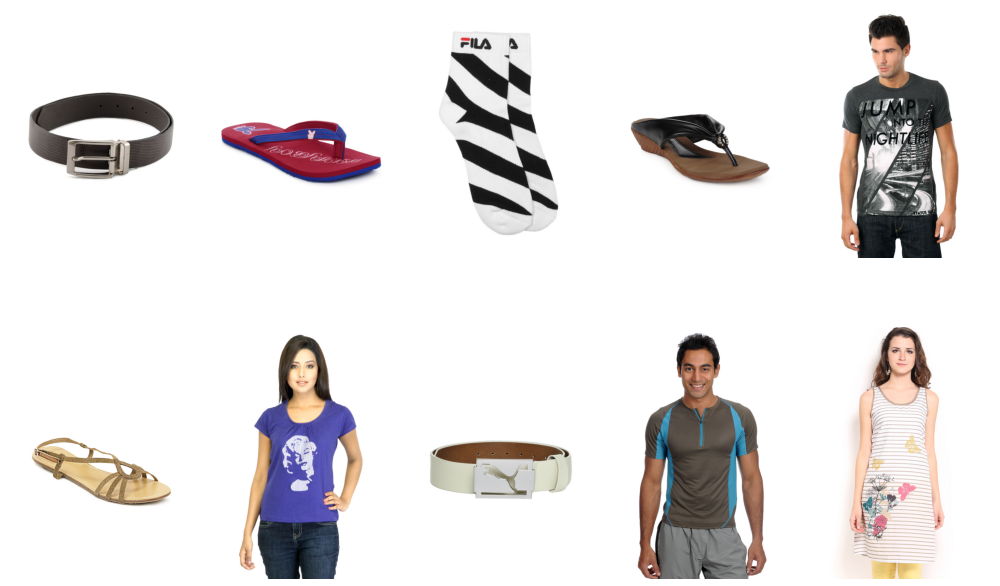

In [ ]:
#lets check some random image as well 
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(14, 10))
random_img = style_df['image_path'].sample(10).values
random_img = [cv2.cvtColor(cv2.imread(i), cv2.COLOR_BGR2RGB) for i in random_img]
#print(random_img)
for idx, img in enumerate(random_img):
    if idx <= 4:
        axes[0,idx].imshow(img)
        axes[0, idx].axis('off')
    else:
        axes[1, idx-5].imshow(img)
        axes[1, idx-5].axis('off')
        
plt.tight_layout()
plt.show()


In [ ]:
#we can do EDA about gender and speific appearal for seasonality (Summer / winter kind of ) but for now we just skip
#these , as we will consider all these data we have to make generalized model.
# we will try here resnet50 for transfer learning model to check how it works , a it is one of the most basic model 
#the latest being Assemble resnet(which is 5 times faster and same accuracy of efficient net B7 + Augumentaiton -> 84.4%) SOTA 
# we will see of we can give it try for assemble-net 


In [ ]:
#from tensorflow.keras.applications.resnet50 import ResNet50

#resnet50_model = ResNet50(weights='imagenet',
 ##                input_shape=(224, 224, 3),
   #               pooling='max')

#resnet50_model.trainable = False
#resnet50_model.summary()

In [ ]:
 #to scale up the CNN, the depth of layers should increase 20%, the width 10% and the image resolution 15% to keep things as efficient as possible while 
 #expanding the implementation and improving the CNN accuracy.
#This compound scaling formula is used to scale up the EfficientNet from B0-B7 --> We will check it later ..



In [ ]:
import keras
from keras import Model
from keras.applications.resnet50 import ResNet50
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
from keras.layers import GlobalMaxPooling2D

In [ ]:
img_width, img_height, _ = 224, 224, 3 #load_image(df.iloc[0].image).shape

# Pre-Trained Model
base_model = ResNet50(weights='imagenet', 
                      include_top=False, 
                      input_shape = (img_width, img_height, 3))
base_model.trainable = False

# Add Layer Embedding
model = keras.Sequential([
    base_model,
    GlobalMaxPooling2D()
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_max_pooling2d_1 (Glob (None, 2048)              0         
Total params: 23,587,712
Trainable params: 0
Non-trainable params: 23,587,712
_________________________________________________________________


In [ ]:
#now get the embedding
from tensorflow.keras.preprocessing.image import load_img, img_to_array
#from efficientnet.tfkeras import center_crop_and_resize, preprocess_input
def get_embedding(model, img_path):
    
    img = load_img(img_path, target_size=(300, 300))
    img = img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = preprocess_input(img)
    
    return model.predict(img).reshape(-1)

In [ ]:
emb = get_embedding(model, style_df.iloc[1000].image_path)
emb.shape

(2048,)

In [ ]:
#lets plot it after embedding
def show_image(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(14, 8))
    plt.imshow(image)
    plt.axis('off')
    plt.show()

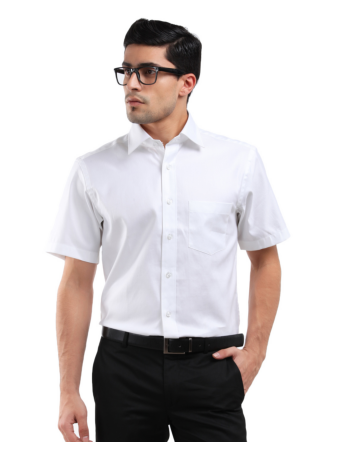

In [ ]:
show_image(style_df.iloc[1000].image_path)

In [ ]:
style_df.drop([6695], inplace=True) #image that crashes 
#style_df.drop([39403], inplace=True)

In [ ]:
map_embeddings = style_df['image_path'].apply(lambda img_path: get_embedding(model, img_path))
df_embs = map_embeddings.apply(pd.Series)

In [ ]:
#the above takes around 1:30 hrs in GPU (if it does not crash)

In [ ]:
from sklearn.metrics.pairwise import pairwise_distances

# Calculate Distance Matrix
cosine_sim = 1 - pairwise_distances(df_embs, metric='cosine')
cosine_sim[:4, :4]

array([[0.9999996 , 0.72475785, 0.56179136, 0.71131444],
       [0.72475785, 0.9999989 , 0.53394395, 0.8243305 ],
       [0.56179136, 0.53394395, 0.99999994, 0.5678497 ],
       [0.71131444, 0.8243305 , 0.5678497 , 1.        ]], dtype=float32)

In [ ]:
indices = pd.Series(range(len(style_df)), index=style_df.index)

# Function to get recommendations based on the cosine similarity score
def get_recommender1(idx, top_n = 6):
    sim_idx    = indices[idx]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1: top_n+1]
    
    idx_rec    = [i[0] for i in sim_scores] # index
    idx_sim    = [i[1] for i in sim_scores] # similarity
    
    return indices.iloc[idx_rec].index, idx_sim

In [ ]:
def get_recommender2(idx, top_n = 6):
    sim_idx    = indices[idx+1]
    sim_scores = list(enumerate(cosine_sim[sim_idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1: top_n+1]
    
    idx_rec    = [i[0] for i in sim_scores] # index
    idx_sim    = [i[1] for i in sim_scores] # similarity
    
    return indices.iloc[idx_rec].index, idx_sim


In [ ]:
def load_image(img):
    image = cv2.imread(img)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return image

def plot_figures(figures, nrows = 2, ncols=3, figsize=(8, 8)):

    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)
    
    for ind, title in enumerate(figures):
        # walaupun 2x3 tetap bisa di-loop klo di-ravel
        axes.ravel()[ind].imshow(figures[title])
        axes.ravel()[ind].set_title(title)
        axes.ravel()[ind].set_axis_off()
    plt.tight_layout() # optional

In [ ]:
def show_recommender(idx):
    ## 0-9999 index as we have 10k images 
    try:
        if idx < 6695:
    
            # Recommendations
            idx_rec, idx_sim = get_recommender1(idx)
    
            # Plot
            plt.imshow(load_image(style_df.iloc[idx].image_path))
            plt.title(style_df.iloc[idx].productDisplayName)
            plt.axis('off')
    
            # generation of a dictionary of (title, images)
            figures = {'im ' + str(i): load_image(row.image_path) for i, row in style_df.loc[idx_rec].iterrows()}
    
            # plot of the images in a figure, with 2 rows and 3 columns
            plot_figures(figures)
        
        elif idx > 6695:
        
            # Recommendations
            idx_rec, idx_sim = get_recommender2(idx)
    
            # Plot
            plt.imshow(load_image(style_df.iloc[idx].image_path))
            plt.title(style_df.iloc[idx].productDisplayName)
            plt.axis('off')
    
            # generation of a dictionary of (title, images)
            figures = {'im ' + str(i-1): load_image(row.image_path) for i, row in style_df.loc[idx_rec].iterrows()}
    
            # plot of the images in a figure, with 2 rows and 3 columns
            plot_figures(figures)
        
    except:
        print('Please insert a number between 0 - 14998\nPlease notice: insert number 6695 will throw an error')


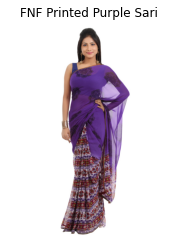

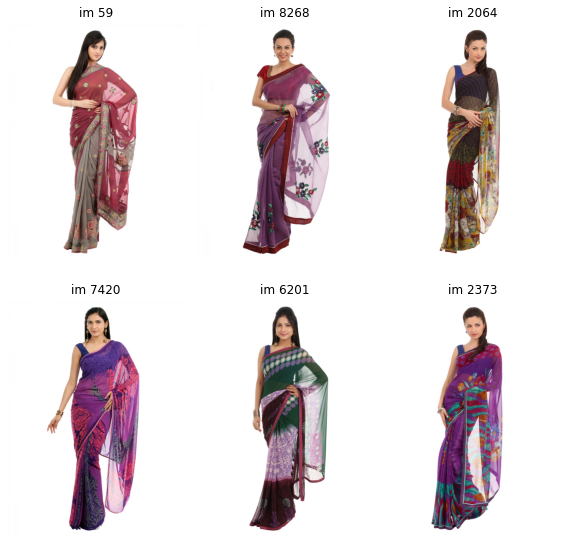

In [ ]:
show_recommender(7000)